In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

In [51]:
def doMSEPlot(perf_IPCRatio, gem5_default_IPCRatio, gem5_edited_IPCRatio, benchmark_name):

    mse_default = np.mean((gem5_default_IPCRatio - 1.0) ** 2)

    mse_edited = np.mean(((gem5_edited_IPCRatio - 1.0)) ** 2)

    categories = ['Original Config', 'New Config']
    values = [mse_default, mse_edited]
    colors = ['steelblue', 'steelblue']

    print((mse_default - mse_edited)/mse_default)
    # Plotting
    plt.bar(categories, values, color=colors)

    # Axis labels
    plt.ylabel('Mean Squared Error with perf Baseline', fontsize = 12, fontweight = 'bold')

    # Set y-axis ticks and labels
    plt.gca().invert_yaxis()

    # Title
    plt.title('IPC Ratio Mean Squared Error for ' + benchmark_name, fontsize = 12, fontweight = 'bold')

    # Show the plot
    plt.show()

In [52]:
def doMSLEPlot(perf_IPCRatio, gem5_default_IPCRatio, gem5_edited_IPCRatio, benchmark_name):

    msle_default = np.e**(np.sqrt(np.sum((np.log(gem5_default_IPCRatio/perf_IPCRatio)) ** 2)/len(gem5_default_IPCRatio)))

    msle_edited = np.e**(np.sqrt(np.sum((np.log(gem5_edited_IPCRatio/perf_IPCRatio)) ** 2)/len(gem5_edited_IPCRatio)))

    categories = ['Original Config', 'New Config']
    values = [msle_default, msle_edited]
    colors = ['steelblue', 'steelblue']

    # Plotting
    plt.bar(categories, values, color=colors)

    # Axis labels
    plt.ylabel('Mean Squared Logarithmic Error', fontsize = 10, fontweight = 'bold')

    # Set y-axis ticks and labels
    plt.gca().invert_yaxis()

    # Title
    plt.title('Mean Squared Logarithmic Error for IPC of ' + benchmark_name, fontsize = 10, fontweight = 'bold')

    # Show the plot
    plt.show()

In [53]:
def doIPCRatioPlot(merged_df, gem5_instructions_rel, gem5_config_edits_instructions_rel, benchmark_name):

    split_index = len(merged_df) // 2
    first_half_gem5 = gem5_instructions_rel[:split_index]
    second_half_gem5 = gem5_instructions_rel[split_index:]
    first_half_config_edits = gem5_config_edits_instructions_rel[:split_index]
    second_half_config_edits = gem5_config_edits_instructions_rel[split_index:]

    # Set up the figure and axes with a wider figsize
    fig, ax = plt.subplots(nrows=2, figsize=(20, 10))

    # Set the bar positions
    x_pos = np.arange(len(first_half_gem5))

    # Set the width of each bar
    width = 0.2

    # Calculate the difference from 1 for the modified data values
    diff_first_half_config_edits = [x-1 if x > 1.0 else 1 + -1/x for x in first_half_config_edits]
    diff_first_half_gem5 = [x-1 if x > 1.0 else 1 + -1/x for x in first_half_gem5]
    diff_second_half_config_edits = [x - 1 if x > 1.0 else 1 + -1/x for x in second_half_config_edits]
    diff_second_half_gem5 = [x-1 if x > 1.0 else 1 + -1/x for x in second_half_gem5]

    ax[0].axhline(y=1, color='black', alpha=0)
    ax[0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)
    ax[0].axhline(y=-1, color='black', alpha=0)
    ax[0].bar(x_pos, diff_first_half_config_edits, width=width, label="gem5_riscvmatched_new_config")
    ax[0].bar(x_pos + width, diff_first_half_gem5, width=width, label="gem5_riscvmatched_original_config")
    ax[0].set_xticks(x_pos)
    ax[0].set_xticklabels(merged_df["Benchmark"][:split_index], rotation=25, fontsize=14)
    ax[0].set_ylabel("Normalized IPC Deviation", fontsize=14, fontweight='bold')
    ax[0].set_title("Normalized IPC Ratio of gem5 with perf for " + benchmark_name, fontsize=16, fontweight='bold')
    ax[0].legend()
    ax[0].set_yticklabels(ax[0].get_yticks())
    ax[0].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.get_text()) + 1 if float(tick.get_text()) >= 0 else float(tick.get_text()) - 1 for tick in ax[0].get_yticklabels()])


    # Plot the second half of gem5 and config_edits in the second subplot
    x_pos = np.arange(len(second_half_gem5))
    ax[1].axhline(y=1, color='black', alpha=0)
    ax[1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)
    ax[1].axhline(y=-1, color='black', alpha=0)
    ax[1].bar(x_pos, diff_second_half_config_edits, width=width, label="gem5_riscvmatched_new_config")
    ax[1].bar(x_pos + width, diff_second_half_gem5, width=width, label="gem5_riscvmatched_original_config")
    ax[1].set_xlabel("Benchmark", fontsize=14, fontweight='bold')
    ax[1].set_ylabel("Normalized IPC Ratio", fontsize=14, fontweight='bold')
    ax[1].legend()
    ax[1].set_xticks(x_pos)
    ax[1].set_xticklabels(merged_df["Benchmark"][split_index:], rotation=25, fontsize=14)
    ax[1].set_yticklabels(ax[1].get_yticks())
    ax[1].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.get_text()) + 1 if float(tick.get_text()) >= 0 else float(tick.get_text()) - 1 for tick in ax[1].get_yticklabels()])

    ax[0].tick_params(labelbottom=True)

    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=25)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=25)

    plt.show()

In [54]:
def preprocess(perf_df, gem5_df, gem5_config_edits_df):
    gem5_config_edits_df = gem5_config_edits_df.rename(columns=lambda x: x + '_gem5_config_edits' if x != 'Benchmark' else x)
    perf_df = perf_df.rename(columns=lambda x: x + '_perf' if x != 'Benchmark' else x)
    gem5_df = gem5_df.rename(columns=lambda x: x + '_gem5' if x != 'Benchmark' else x)

    # Merge the data frames on the "Benchmark" column
    merged_df = perf_df.merge(gem5_df, on="Benchmark", suffixes=("_perf", "_gem5")) \
    .merge(gem5_config_edits_df, on="Benchmark", suffixes=("_gem5", "_gem5_config_edits"))

    # Get the order of the names in the perf_df data frame
    name_order = perf_df["Benchmark"].tolist()

    merged_df["IPC_perf"] = merged_df["Instructions_perf"] / merged_df["Cycles_perf"]

    try:
        merged_df["IPC_gem5"] = merged_df["Instructions_gem5"] / merged_df["Cycles_gem5"]
        merged_df["IPC_gem5_config_edits"] = merged_df["Instructions_gem5_config_edits"] / merged_df["Cycles_gem5_config_edits"]
    except:
        pass


    perf_IPC = merged_df["IPC_perf"]
    gem5_IPC_rel = ((merged_df["IPC_gem5"]) / perf_IPC)
    gem5_config_edits_IPC_rel = ((merged_df["IPC_gem5_config_edits"]) / perf_IPC)

    return merged_df, perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel

In [55]:
csvs_directory = Path("./csvs/")
try:
    os.chdir(csvs_directory)
except:
    pass

In [56]:
# Vertical Research Groups Microbenchmark Suite

perf_df = pd.read_csv("perf_VRG_microbenchmarks.csv")
gem5_df = pd.read_csv("gem5_original_config_VRG_microbenchmarks.csv")
gem5_config_edits_df = pd.read_csv("gem5_new_config_VRG_microbenchmarks.csv")
merged_df, perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel = preprocess(perf_df, gem5_df, gem5_config_edits_df)

/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.get_text()) + 1 if float(tick.get_text()) >= 0 else float(tick.get_text()) - 1 for tick in ax[0].get_yticklabels()])
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.g

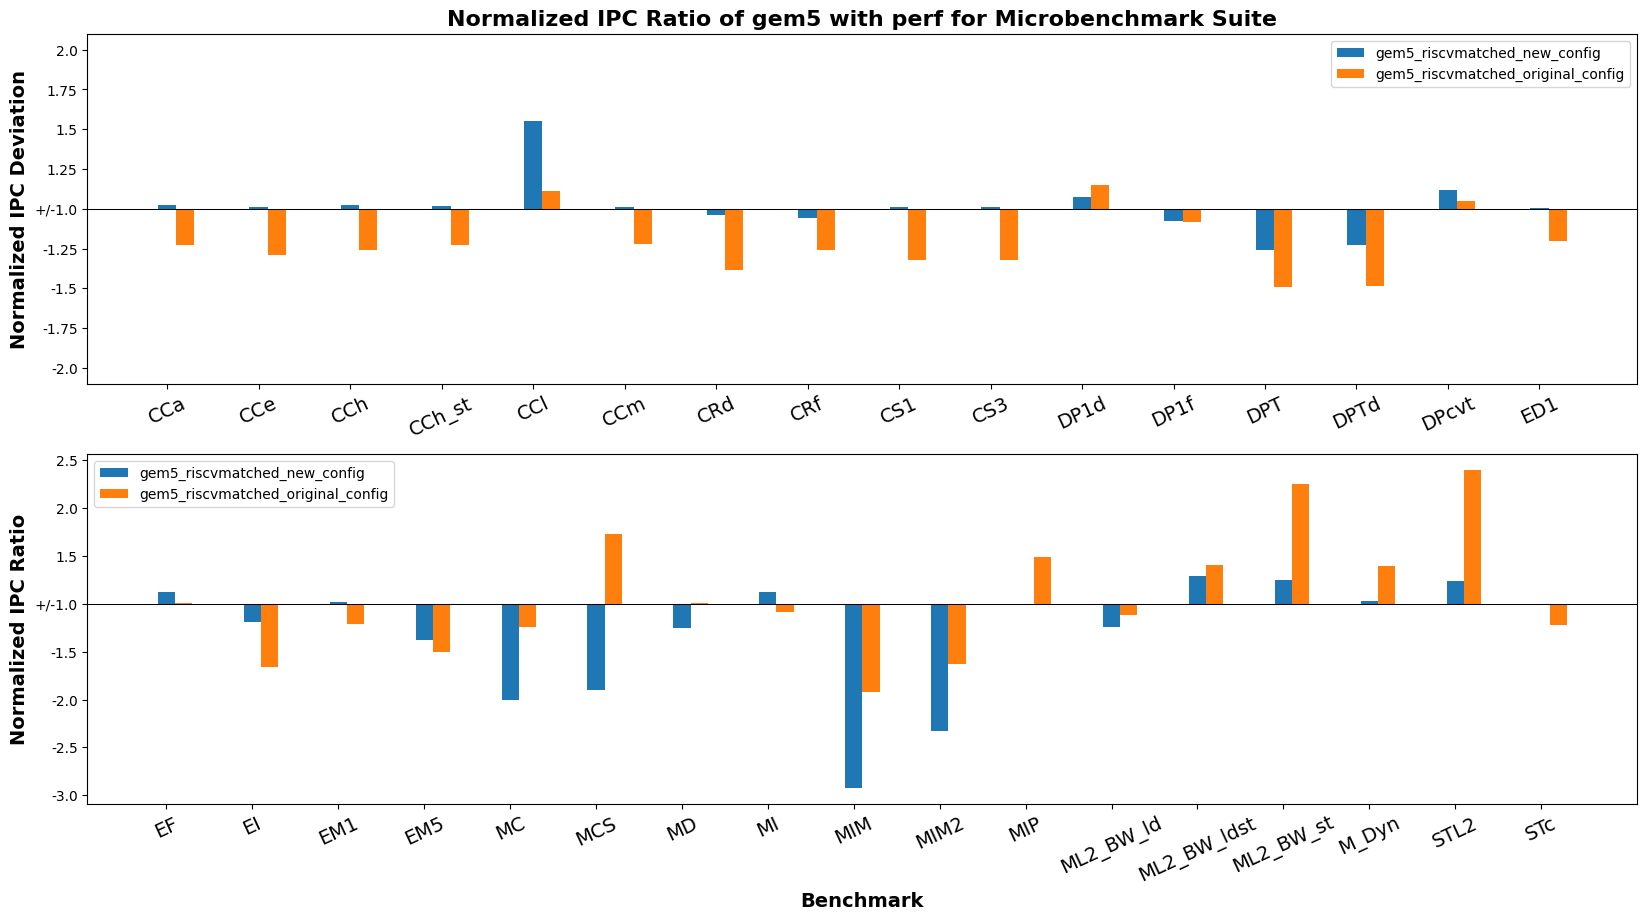

In [57]:
doIPCRatioPlot(merged_df, gem5_IPC_rel, gem5_config_edits_IPC_rel, "Microbenchmark Suite")

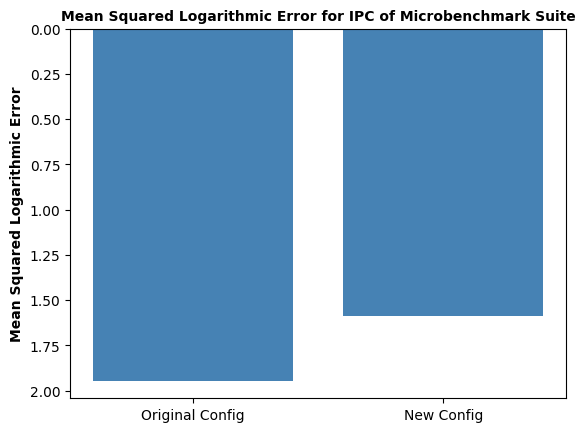

In [58]:
doMSLEPlot(perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel, "Microbenchmark Suite")

In [59]:
# SPEC2006 Ref Subset

perf_df = pd.read_csv("perf_SPEC2006_subset_ref.csv")
gem5_df = pd.read_csv("gem5_original_config_SPEC2006_subset_ref.csv")
gem5_config_edits_df = pd.read_csv("gem5_new_config_SPEC2006_subset_ref.csv")

merged_df, perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel = preprocess(perf_df, gem5_df, gem5_config_edits_df)

/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.get_text()) + 1 if float(tick.get_text()) >= 0 else float(tick.get_text()) - 1 for tick in ax[0].get_yticklabels()])
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.g

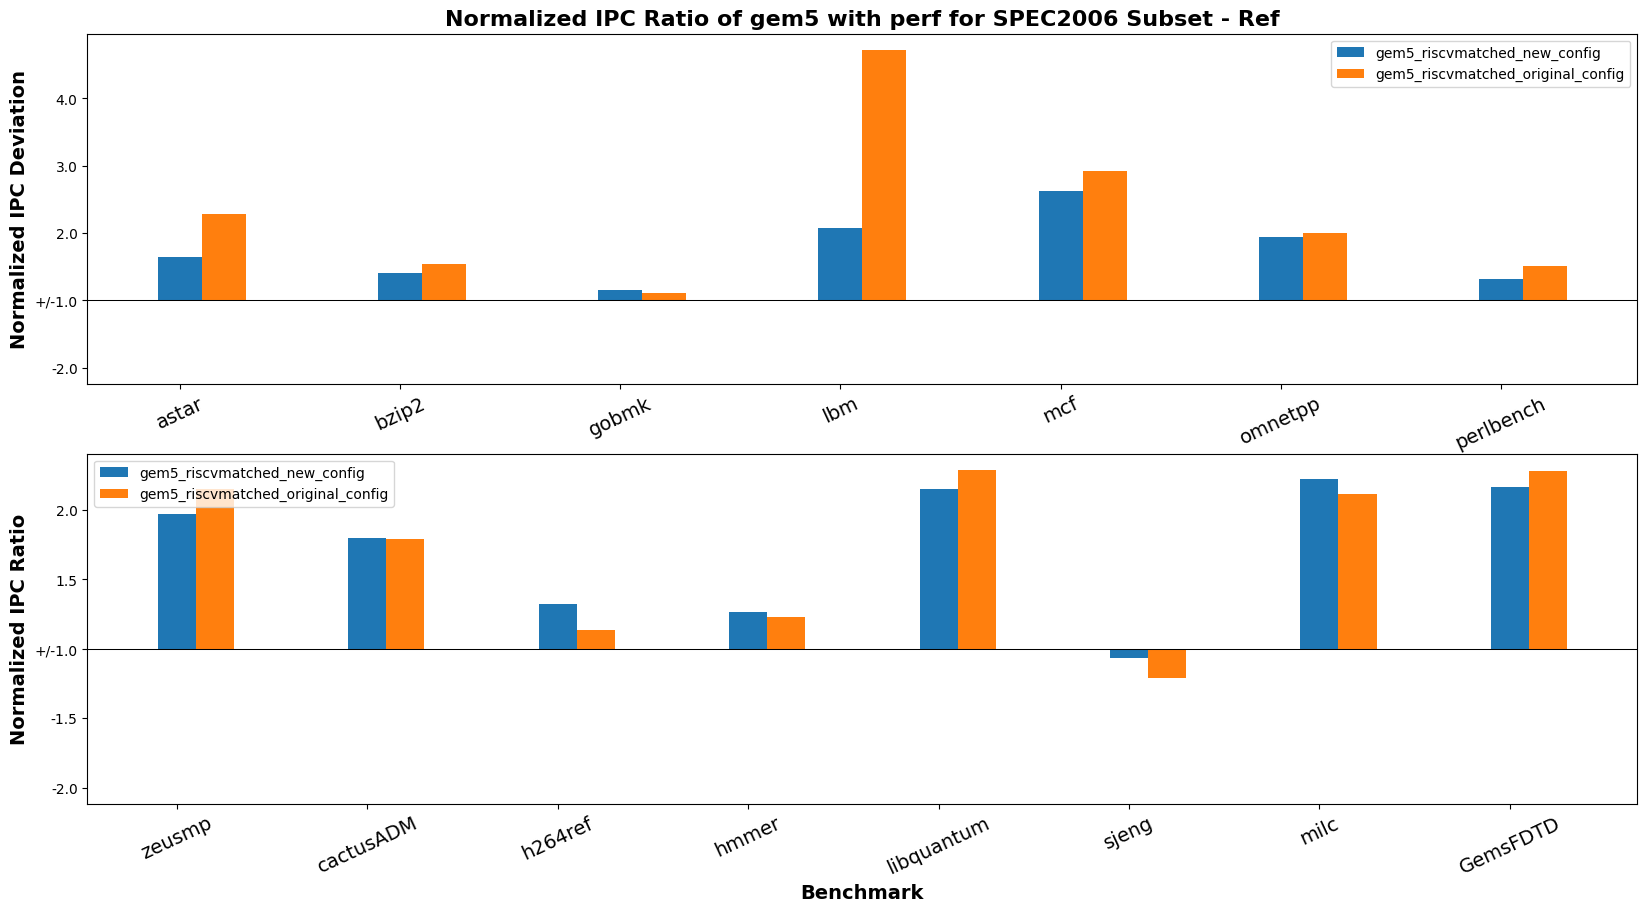

In [60]:
doIPCRatioPlot(merged_df, gem5_IPC_rel, gem5_config_edits_IPC_rel, "SPEC2006 Subset - Ref")

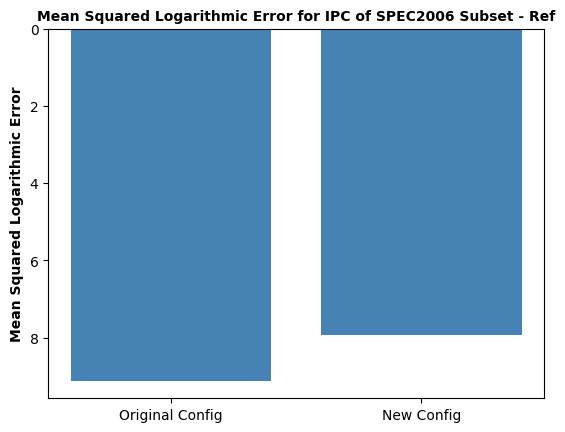

In [61]:
doMSLEPlot(perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel, "SPEC2006 Subset - Ref")

In [62]:
perf_df = pd.read_csv("perf_SPEC2006_subset_train.csv")
gem5_df = pd.read_csv("gem5_original_config_SPEC2006_subset_train.csv")
gem5_config_edits_df = pd.read_csv("gem5_new_config_SPEC2006_subset_train.csv")

merged_df, perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel = preprocess(perf_df, gem5_df, gem5_config_edits_df)

/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.get_text()) + 1 if float(tick.get_text()) >= 0 else float(tick.get_text()) - 1 for tick in ax[0].get_yticklabels()])
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticks())
/var/folders/7f/9g_jq5js7ng143k2lzt28yg40000gn/T/ipykernel_17382/3552402481.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['+/-1.0' if float(tick.get_text()) == 0 else float(tick.g

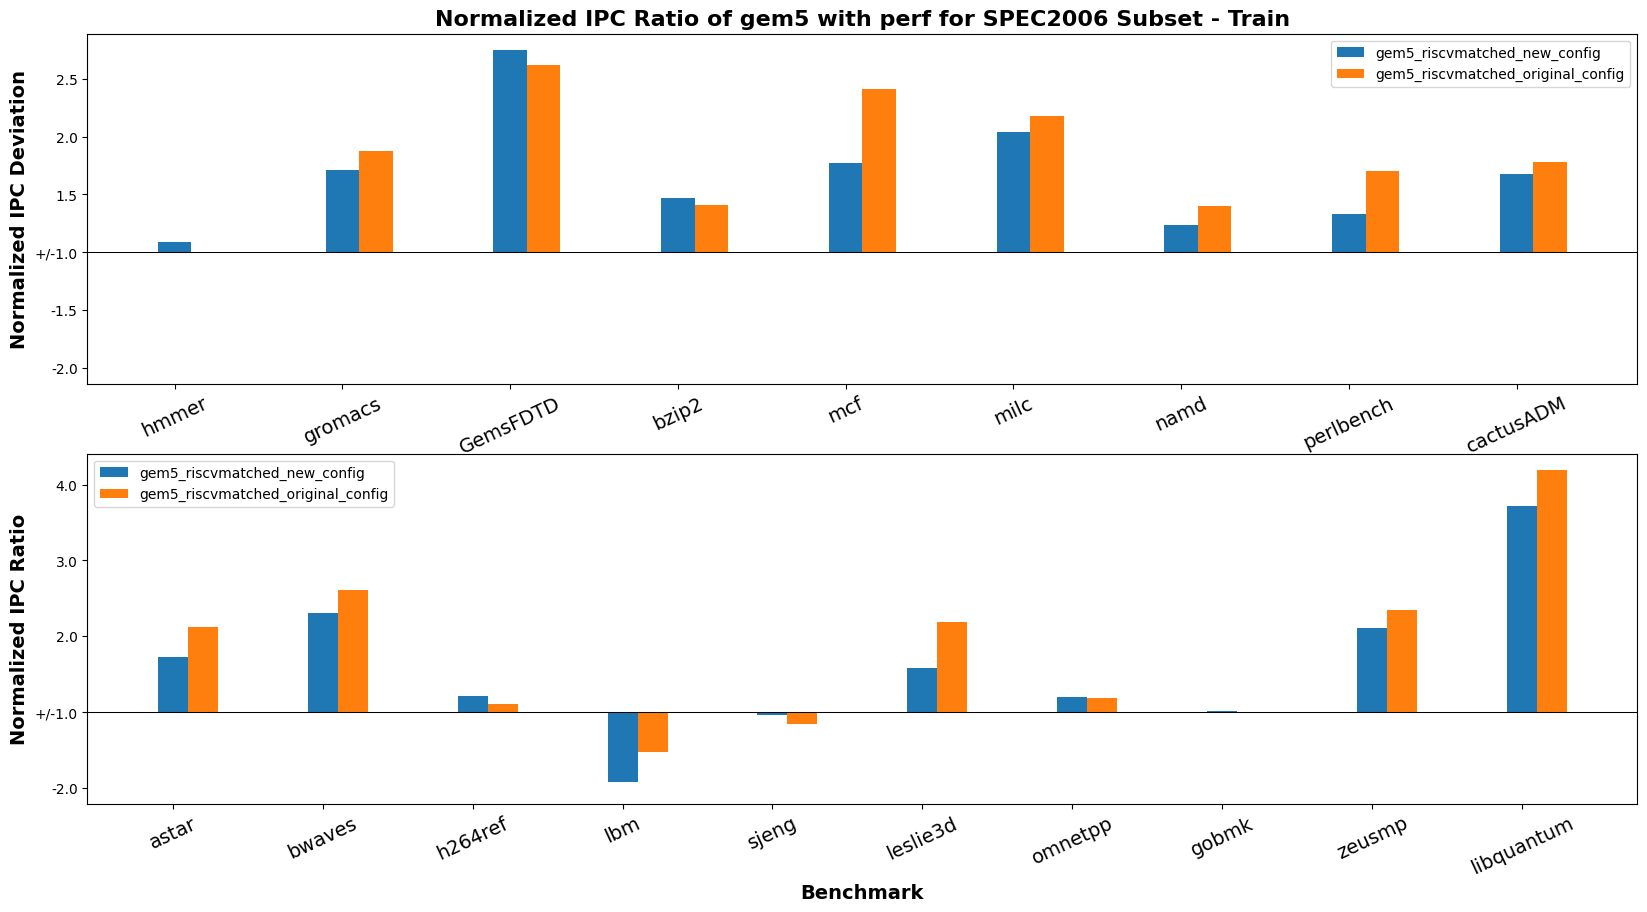

In [63]:
doIPCRatioPlot(merged_df, gem5_IPC_rel, gem5_config_edits_IPC_rel, "SPEC2006 Subset - Train")

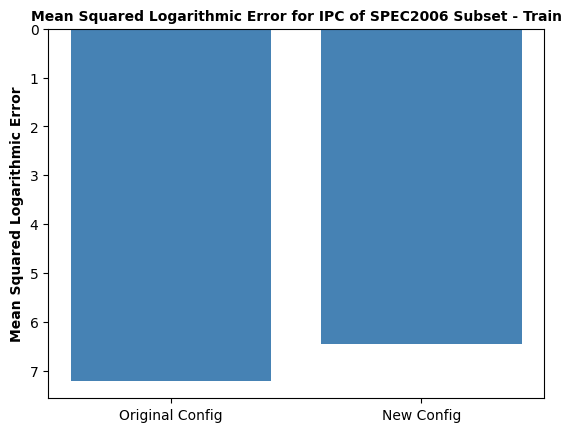

In [64]:
doMSLEPlot(perf_IPC, gem5_IPC_rel, gem5_config_edits_IPC_rel, "SPEC2006 Subset - Train")

Text(0.5, 1.0, 'Mean IPC for SPEC2006 Train Subset - gem5 Full Run vs gem5 SimPoints')

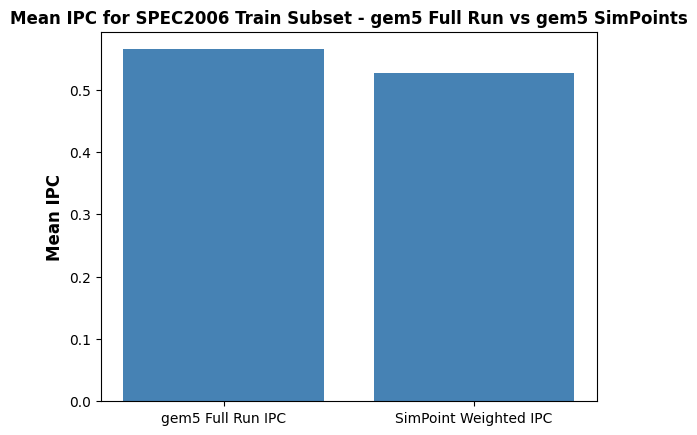

In [65]:
fullrun_df = pd.read_csv("gem5_original_config_fullrun_SPEC2006_train.csv")
simpoints_df = pd.read_csv("gem5_original_config_SPEC2006_subset_train.csv")

fullrun_df = fullrun_df.rename(columns=lambda x: x + '_fullrun' if x != 'Benchmark' else x)
simpoints_df = simpoints_df.rename(columns=lambda x: x + '_simpoints' if x != 'Benchmark' else x)


merged_df = fullrun_df.merge(simpoints_df, on="Benchmark")

# Get the order of the names in the fullrun_df data frame
name_order = fullrun_df["Benchmark"].tolist()


# Reorder the merged data frame based on the order in fullrun_df
merged_df = merged_df.set_index("Benchmark").loc[name_order].reset_index()


fullrun_IPC = (merged_df["Total Instructions_fullrun"]/merged_df["Total Cycles_fullrun"])
simpoints_IPC = merged_df["IPC_simpoints"]


fullrun_mean_IPC = np.mean(fullrun_IPC)

simpoints_mean_IPC = np.mean(simpoints_IPC)

categories = ['gem5 Full Run IPC', 'SimPoint Weighted IPC']
values = [fullrun_mean_IPC, simpoints_mean_IPC]
colors = ['steelblue', 'steelblue']

# Plotting
plt.bar(categories, values, color=colors)

# Axis labels
plt.ylabel('Mean IPC', fontsize = 12, fontweight = 'bold')

# Title
plt.title('Mean IPC for SPEC2006 Train Subset - gem5 Full Run vs gem5 SimPoints', fontsize = 12, fontweight = 'bold')